# Teeth infection detection

**British university in Egypt** \\
*ICS*

---

### STUDENT DETAIL:
- **Omar Islam**
  - Email: omar219127@bue.edu.eg
  - Student ID: 219127


---




## Contribution

1. Creating the dataset necessary for training the model.
2. Preprocessing the dataset.
3. Using YOLOv5 to train the model.
4. Printing the scores of the model.
5. Testing the model.

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile

zip_file_path = '/content/drive/MyDrive/Benchmarking Dataset.zip'
extracted_dir_path = '/content/extracted_dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print(f"Zip file '{zip_file_path}' extracted to '{extracted_dir_path}'")
!ls {extracted_dir_path}

Zip file '/content/drive/MyDrive/Benchmarking Dataset.zip' extracted to '/content/extracted_dataset'
'Benchmarking Dataset'


In [ ]:
!ls "{extracted_dir_path}"

'Benchmarking Dataset'


## Setting up the Environment

### Imports

In [ ]:
import os, yaml, random, shutil, cv2
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

### Setting up the directories

In [ ]:
ROOT = Path("/content/extracted_dataset/Benchmarking Dataset")
DATA = ROOT / "Benchmarking Dataset"

IMG_DIRS  = [DATA / 'train/images', DATA / 'valid/images', DATA / 'test/images']
LBL_DIRS  = [p.with_name('labels') for p in IMG_DIRS]

In [ ]:
print("Image directories:", IMG_DIRS)
print("Label directories:", LBL_DIRS)

Image directories: [PosixPath('/content/extracted_dataset/Benchmarking Dataset/Benchmarking Dataset/train/images'), PosixPath('/content/extracted_dataset/Benchmarking Dataset/Benchmarking Dataset/valid/images'), PosixPath('/content/extracted_dataset/Benchmarking Dataset/Benchmarking Dataset/test/images')]
Label directories: [PosixPath('/content/extracted_dataset/Benchmarking Dataset/Benchmarking Dataset/train/labels'), PosixPath('/content/extracted_dataset/Benchmarking Dataset/Benchmarking Dataset/valid/labels'), PosixPath('/content/extracted_dataset/Benchmarking Dataset/Benchmarking Dataset/test/labels')]


## Sanity-check files

In [ ]:
def check_pairs(img_dir, lbl_dir):
    imgs = list(img_dir.glob('*.jpg'))
    missing = []
    for img in imgs:
        lbl = lbl_dir / f"{img.stem}.txt"
        if not lbl.exists(): missing.append(img.name)
    return imgs, missing

In [ ]:
total_imgs, missing_labels = 0, []
for img_d, lbl_d in zip(IMG_DIRS, LBL_DIRS):
    ims, miss = check_pairs(img_d, lbl_d)
    total_imgs += len(ims);  missing_labels.extend(miss)
print(f"Total images: {total_imgs}")
print(f"Images w/o label file: {len(missing_labels)} ⇒ {missing_labels[:5]}")

Total images: 2227
Images w/o label file: 0 ⇒ []


### IF alot of unlabeled files detected

In [ ]:
for img_name in missing_labels:
    for split in ('train','valid','test'):
        (DATA/f'{split}/images'/img_name).unlink(missing_ok=True)

## Class distribution

In [ ]:
class_counts = {}
for lbl_d in LBL_DIRS:
    for txt in lbl_d.glob('*.txt'):
        with open(txt) as f:
            for line in f:
                cls = int(line.split()[0])
                class_counts[cls] = class_counts.get(cls, 0)+1
print("Class counts:", class_counts)   # {0: healthy, 1: infected}

Class counts: {0: 6174, 1: 554}


## Visualize

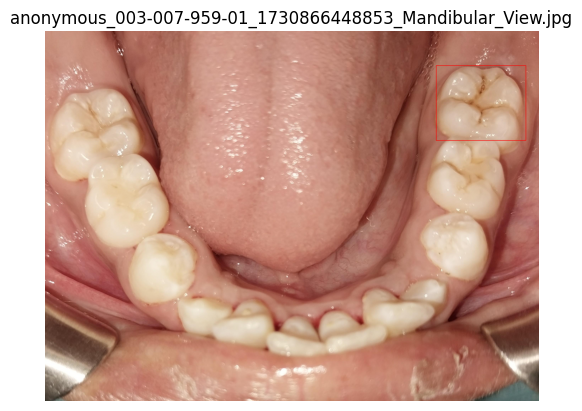

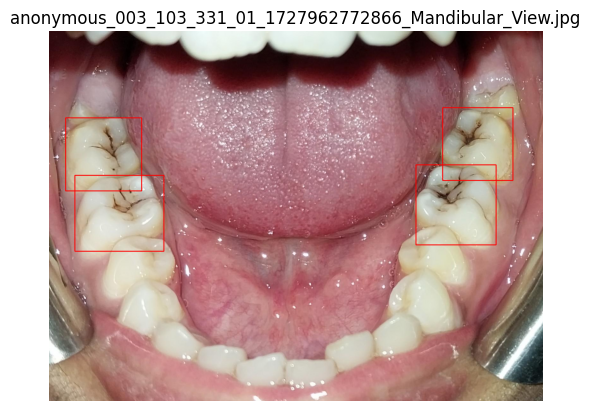

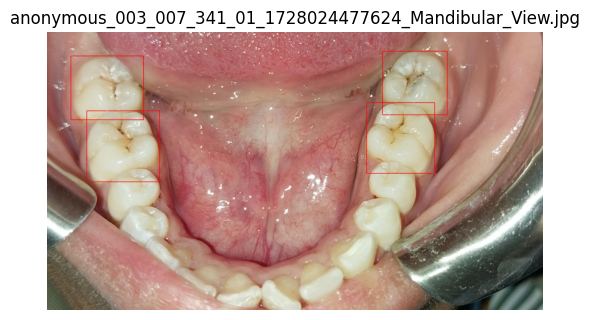

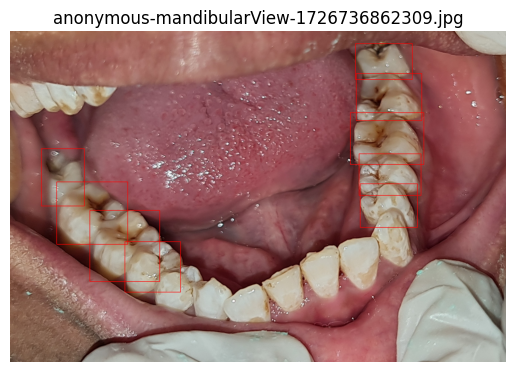

In [ ]:
def show_sample(n=4, split='train'):
    img_dir, lbl_dir = DATA/f'{split}/images', DATA/f'{split}/labels'
    for img_path in random.sample(list(img_dir.glob('*.jpg')), n):
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        with open(lbl_dir/f'{img_path.stem}.txt') as f:
            for ln in f:
                c, xc,yc,bw,bh = map(float, ln.split())
                x1,y1 = int((xc-bw/2)*w), int((yc-bh/2)*h)
                x2,y2 = int((xc+bw/2)*w), int((yc+bh/2)*h)
                cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
        plt.imshow(img); plt.axis('off'); plt.title(img_path.name)
        plt.show()
show_sample()

# Train using YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17488, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 17488 (delta 0), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17488/17488), 16.55 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:0

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving data.yaml to data.yaml


In [ ]:
!rm -f yolov5  # remove any file named yolov5
!git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 17488, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 17488 (delta 0), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17488/17488), 16.59 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.


In [ ]:
!ls -l


total 440
-rw-r--r-- 1 root root 14146 Jun 12 08:54 benchmarks.py
-rw-r--r-- 1 root root   393 Jun 12 08:54 CITATION.cff
drwxr-xr-x 2 root root  4096 Jun 12 08:54 classify
-rw-r--r-- 1 root root  5419 Jun 12 08:54 CONTRIBUTING.md
drwxr-xr-x 5 root root  4096 Jun 12 08:54 data
-rw-r--r-- 1 root root   219 Jun 12 08:56 data.yaml
-rw-r--r-- 1 root root 23761 Jun 12 08:54 detect.py
-rw-r--r-- 1 root root 68577 Jun 12 08:54 export.py
-rw-r--r-- 1 root root 23997 Jun 12 08:54 hubconf.py
-rw-r--r-- 1 root root 34523 Jun 12 08:54 LICENSE
drwxr-xr-x 4 root root  4096 Jun 12 08:54 models
-rw-r--r-- 1 root root  5341 Jun 12 08:54 pyproject.toml
-rw-r--r-- 1 root root 49999 Jun 12 08:54 README.md
-rw-r--r-- 1 root root 48968 Jun 12 08:54 README.zh-CN.md
-rw-r--r-- 1 root root  1598 Jun 12 08:54 requirements.txt
drwxr-xr-x 2 root root  4096 Jun 12 08:54 segment
-rw-r--r-- 1 root root 47157 Jun 12 08:54 train.py
-rw-r--r-- 1 root root 40830 Jun 12 08:54 tutorial.ipynb
drwxr-xr-x 8 root root  4096 Ju

In [ ]:
!mv data.yaml yolov5/


In [ ]:
%cd yolov5
!python train.py --img 640 --batch 16 --epochs 50 \
        --data data.yaml --weights yolov5s.pt --name teeth_yolov5s

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      28/49      4.24G    0.02002    0.02392    0.00225         81        640:  25% 28/111 [00:29<01:49,  1.31s/it]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      4.24G    0.02005    0.02396   0.002228         95        640:  26% 29/111 [00:29<01:38,  1.20s/it]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      4.24G    0.01998    0.02393   0.002265         87        640:  27% 30/111 [00:30<01:24,  1.05s/it]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.